In [70]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scvelo as scv
import matplotlib.pyplot as plt
import matplotlib as mpl
import pynndescent
import numba

# Cell type proportions per sample across PSC-, FSC- and ASC-derivations

In [2]:
# Load the Integrated Lung Anndata
adata = sc.read_h5ad('./datasets/lung_heoca_final.h5ad')

In [3]:
# Define cell type colors
cell_type_colors = {
    'basal cells': '#16f648',
    'club cells': '#795548',
    'ciliated cells': '#1c15bc',
    'alveolar type 1 (AT1) cells': '#85C1E9',
    'alveolar type 2 (AT2) cells': '#f1f847',
    'neuroendocrine cells': '#eb1388',
    'airway secretory cells': '#a8bade',
    'goblet cells': '#8e3101',
    'stem cells': '#225805'
}

In [4]:
adata.obs.columns

Index(['sample_id', 'publication', 'sample_name', 'n_genes',
       'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'pct_counts_ribo', 'batch', 'derive', 'time',
       'protocol', 'molecular', 'gel', 'level_1', 'level_2', 'level_3',
       'leiden_res5_l2', 'leiden_res5_l3', 'tissue_ontology_term_id',
       'organism_ontology_term_id', 'assay_ontology_term_id',
       'disease_ontology_term_id', 'cell_type_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'sex_ontology_term_id',
       'donor_id', 'suspension_type', 'is_primary_data', 'cell_type', 'assay',
       'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity',
       'development_stage'],
      dtype='object')

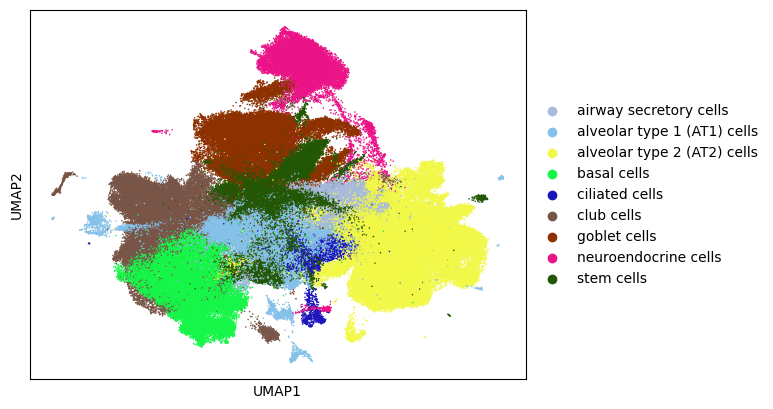

In [15]:
# Final UMAP at desired level 2 resolution
sc.pl.umap(adata, color=['leiden_res5_l2'], palette=cell_type_colors, size=5, title = "")

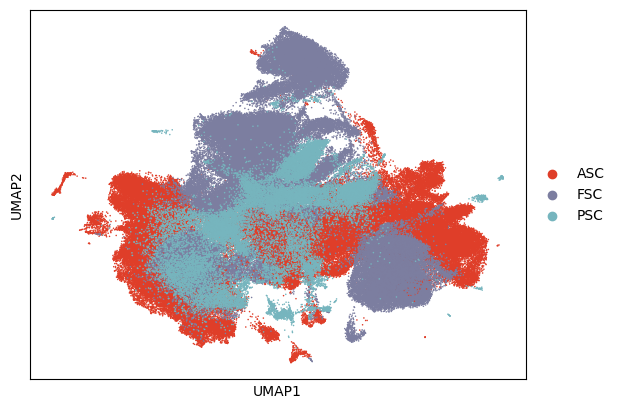

In [18]:
# Analogous UMAP with color-coded derivations
sc.pl.umap(adata, color=['derive'], size=5, palette = ["#df3e29", "#7c7ea0", "#76b5be"], title = "")

In [9]:
# Generate dataframes for cell type composition
df_asc = pd.crosstab(adata[adata.obs.derive == 'ASC'].obs['sample_id'], adata[adata.obs.derive == 'ASC'].obs['leiden_res5_l3'])
df_fsc = pd.crosstab(adata[adata.obs.derive == 'FSC'].obs['sample_id'], adata[adata.obs.derive == 'FSC'].obs['leiden_res5_l3'])
df_ips = pd.crosstab(adata[adata.obs.derive == 'PSC'].obs['sample_id'], adata[adata.obs.derive == 'PSC'].obs['leiden_res5_l3'])

In [10]:
# Normalize dataframes
df_asc_norm = df_asc.div(df_asc.sum(axis=1), axis=0)
df_fsc_norm = df_fsc.div(df_fsc.sum(axis=1), axis=0)
df_ips_norm = df_ips.div(df_ips.sum(axis=1), axis=0)

In [11]:
# Sort dataframes by stem cell proportion
df_asc_norm_sort = df_asc_norm.sort_values(by=['stem cells'], ascending=False)
df_fsc_norm_sort = df_fsc_norm.sort_values(by=['stem cells'], ascending=False)
df_ips_norm_sort = df_ips_norm.sort_values(by=['stem cells'], ascending=False)

In [13]:
# Get cell names
cell_names = df_ips_norm_sort.columns.to_list()

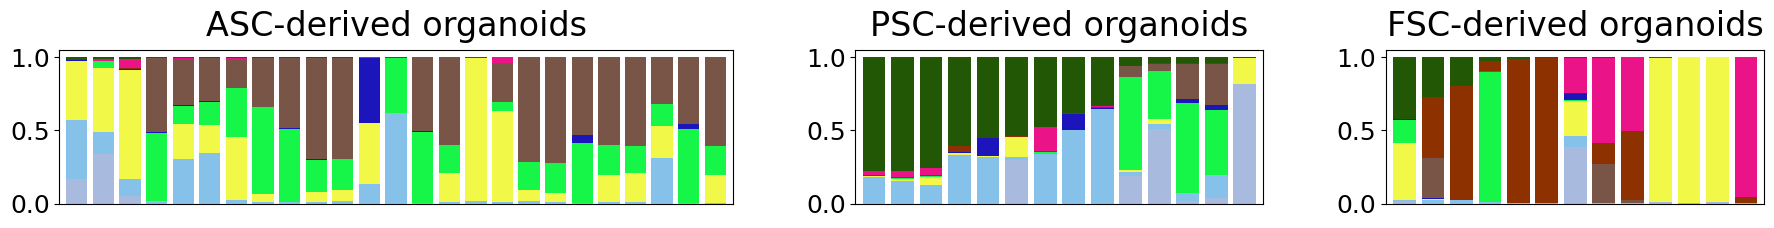

In [14]:
# Generate barplots at desired horizontal proportions
dfs = [df_ips_norm_sort,df_fsc_norm_sort, df_asc_norm_sort]

num_bars_fsc = len(df_fsc_norm_sort)
num_bars_asc = len(df_asc_norm_sort)
num_bars_psc = len(df_ips_norm_sort)
summed_width = num_bars_asc + num_bars_psc + num_bars_fsc
total_width = 10

width_fsc = total_width
width_asc = (num_bars_asc / (summed_width)) * total_width
width_psc = (num_bars_psc / (summed_width)) * total_width

fig = plt.figure(figsize=(22, 2))

gs = fig.add_gridspec(1, summed_width+6)

ax1 = fig.add_subplot(gs[0, :num_bars_asc-2])
ax2 = fig.add_subplot(gs[0, num_bars_asc+2:num_bars_asc+num_bars_psc+2])
ax3 = fig.add_subplot(gs[0, num_bars_asc+num_bars_psc+6:num_bars_asc+num_bars_psc+num_bars_fsc+6])

df_asc_norm_sort[cell_names].plot(kind='bar', width = 0.8, stacked=True, ax=ax1, color=[cell_type_colors[p] for p in cell_names])
df_ips_norm_sort[cell_names].plot(kind='bar', width = 0.8, stacked=True, ax=ax2, color=[cell_type_colors[p] for p in cell_names])
df_fsc_norm_sort[cell_names].plot(kind='bar', width = 0.8, stacked=True, ax=ax3, color=[cell_type_colors[p] for p in cell_names])
ax1.set_title('ASC-derived organoids', fontsize=24, pad = 10)
ax2.set_title('PSC-derived organoids', fontsize=24, pad = 10)
ax3.set_title('FSC-derived organoids', fontsize=24, pad = 10)

ax3.legend(title='Prediction', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, frameon=True)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([]
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()

ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
ax3.tick_params(axis='y', labelsize=18)

plt.show()

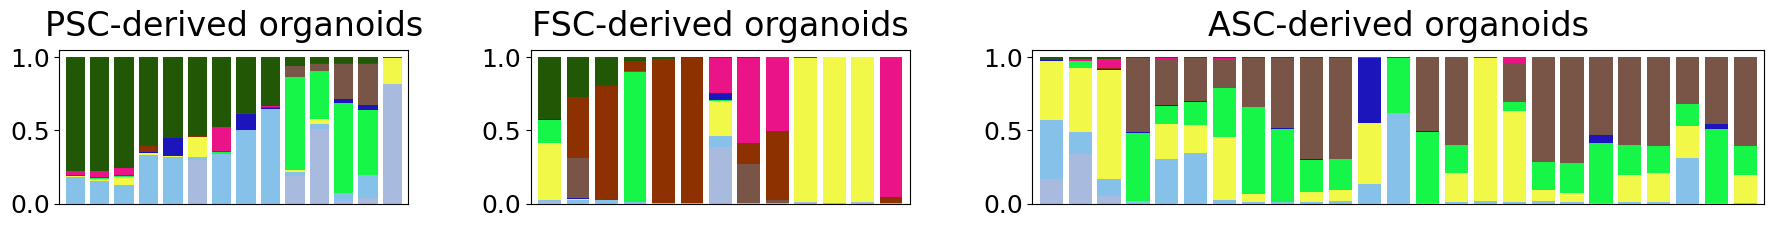

In [25]:
# Reorder barplots by other derivation order
dfs = [df_ips_norm_sort,df_fsc_norm_sort, df_asc_norm_sort]

num_bars_fsc = len(df_fsc_norm_sort)
num_bars_asc = len(df_asc_norm_sort)
num_bars_psc = len(df_ips_norm_sort)
summed_width = num_bars_asc + num_bars_psc + num_bars_fsc
total_width = 10

width_fsc = total_width
width_asc = (num_bars_asc / (summed_width)) * total_width
width_psc = (num_bars_psc / (summed_width)) * total_width

fig = plt.figure(figsize=(22, 2))

gs = fig.add_gridspec(1, summed_width+6)

ax1 = fig.add_subplot(gs[0, :num_bars_psc-2])
ax2 = fig.add_subplot(gs[0, num_bars_psc+2:num_bars_psc+num_bars_fsc+2])
ax3 = fig.add_subplot(gs[0, num_bars_psc+num_bars_fsc+6:num_bars_psc+num_bars_fsc+num_bars_asc+6])


df_ips_norm_sort[cell_names].plot(kind='bar', width = 0.8, stacked=True, ax=ax1, color=[cell_type_colors[p] for p in cell_names])
df_fsc_norm_sort[cell_names].plot(kind='bar', width = 0.8, stacked=True, ax=ax2, color=[cell_type_colors[p] for p in cell_names])
df_asc_norm_sort[cell_names].plot(kind='bar', width = 0.8, stacked=True, ax=ax3, color=[cell_type_colors[p] for p in cell_names])
ax1.set_title('PSC-derived organoids', fontsize=24, pad = 10)
ax2.set_title('FSC-derived organoids', fontsize=24, pad = 10)
ax3.set_title('ASC-derived organoids', fontsize=24, pad = 10)

ax3.legend(title='Prediction', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, frameon=True)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()

ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
ax3.tick_params(axis='y', labelsize=18)

plt.show()

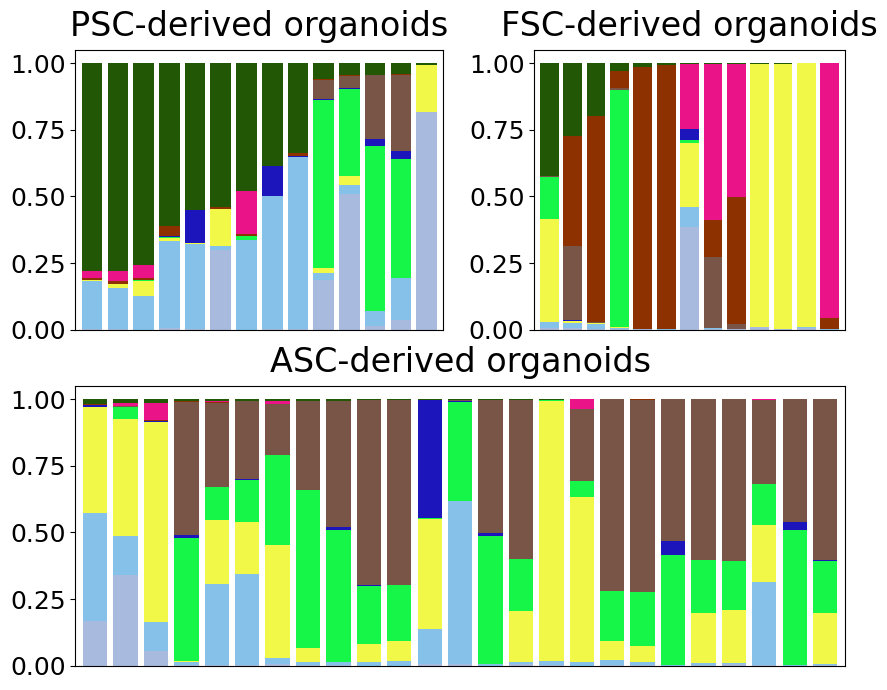

In [30]:
# Stack barplots
dfs = [df_ips_norm_sort,df_fsc_norm_sort, df_asc_norm_sort]

num_bars_fsc = len(df_fsc_norm_sort)
num_bars_asc = len(df_asc_norm_sort)
num_bars_psc = len(df_ips_norm_sort)
summed_width = num_bars_asc + num_bars_psc + num_bars_fsc
total_width = 10

width_fsc = total_width
width_asc = (num_bars_asc / (summed_width)) * total_width
width_psc = (num_bars_psc / (summed_width)) * total_width

fig = plt.figure(figsize=(14, 8))

gs = fig.add_gridspec(2, max(num_bars_psc, num_bars_fsc + num_bars_asc))

ax1 = fig.add_subplot(gs[1, :num_bars_psc+num_bars_fsc])
ax2 = fig.add_subplot(gs[0, :num_bars_psc-1])
ax3 = fig.add_subplot(gs[0, (num_bars_psc+2):num_bars_psc+num_bars_fsc])


df_asc_norm_sort[cell_names].plot(kind='bar', width = 0.8, stacked=True, ax=ax1, color=[cell_type_colors[p] for p in cell_names])
df_ips_norm_sort[cell_names].plot(kind='bar', width = 0.8, stacked=True, ax=ax2, color=[cell_type_colors[p] for p in cell_names])
df_fsc_norm_sort[cell_names].plot(kind='bar', width = 0.8, stacked=True, ax=ax3, color=[cell_type_colors[p] for p in cell_names])
ax1.set_title('ASC-derived organoids', fontsize=24, pad = 10)
ax2.set_title('PSC-derived organoids', fontsize=24, pad = 10)
ax3.set_title('FSC-derived organoids', fontsize=24, pad = 10)

ax3.legend(title='Prediction', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, frameon=True)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()

ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
ax3.tick_params(axis='y', labelsize=18)

plt.show()

# Maturity proportions

CREDIT: Generation of maturity proportion data by Merel Kuijs

In [35]:
adata = sc.read_h5ad("/Users/raphaelkfurirubens/Desktop/Theis_lab/organoids_project/code/datasets/q2r_fetal_adata_latent_v37.h5ad")
adata

AnnData object with n_obs × n_vars = 312317 × 10
    obs: 'level_1', 'level_2', 'sample_id', 'maturity', 'derive', 'query', 'cell_type_pred', 'cell_type_uncert', 'cell_type', 'cell_type_ref'
    uns: 'cell_type_colors', 'cell_type_pred_colors', 'cell_type_ref_colors', 'derive_colors', 'maturity_colors'
    obsm: 'X_umap'

In [36]:
color_palette = {
    'FSC': '#8491B4', 
    'ASC': '#E64B35', 
    'PSC': '#4DBBD5',
    'fetal': '#E68FC6',
    'mature': '#6EA3FA',
    'AT0': '#1F77B4',
    'AT1': '#FF7F0E',
    'AT2': '#279E68',
    'Basal': '#D62728',
    'Bud Tip Progenitor': '#AA40FC',
    'Ciliated': '#8C564B',
    'Club': '#E377C2',
    'Endothelial': '#B5BD61',
    'Goblet': '#17BECF',
    'Ionocyte': '#AEC7E8',
    'Misc': '#0A1172',
    'Neuroendocrine': '#FFBB78',
    'Squamous': '#98DF8A',
    'Stalk': '#FF9896',
    'Tuft': '#C5B0D5',
}

In [37]:
fetal_dict = {
    "Ciliated": "Ciliated",
    "MUC16+ ciliated": "Ciliated",
    "Deuterosomal": "Ciliated",
    "Late airway progenitor": "Club",
    "Mid airway progenitor": "Club",
    "Early tip": "Bud Tip Progenitor",
    "Mid tip": "Bud Tip Progenitor",
    "Late tip": "Bud Tip Progenitor",
    "Pulmonary neuroendocrine": "Neuroendocrine",
    "GHRL+ neuroendocrine": "Neuroendocrine",
    "Pulmonary NE precursor": "Neuroendocrine",
    "GHRL+ NE precursor": "Neuroendocrine",
    "Early airway progenitor": "Club",
    "Early stalk": "Stalk",
    "Mid stalk": "Stalk",
    "Late stalk": "Stalk",
    "AT1": "AT1",
    "AT2": "AT2",
    "Club": "Club",
    "Proximal secretory progenitors": "Club",
    "Proximal secretory 1": "Club",
    "Proximal secretory 2": "Club",
    "Proximal secretory 3": "Club",
    "SMG": "Club",
    "Squamous": "Squamous",
    "Proximal basal": "Basal",
    "Mid basal": "Basal",
    "Late basal": "Basal",
    "SMG basal": "Basal",
    "MUC5AC+ ASCL1+ progenitor": "Misc"
}

mature_dict = {
    "AT0": "AT0",
    "AT1": "AT1",
    "AT2": "AT2",
    "AT2 proliferating": "AT2",
    "Basal resting": "Basal",
    "Club (nasal)": "Club",
    "Club (non-nasal)": "Club",
    "Deuterosomal": "Ciliated",
    "EC aerocyte capillary": "Endothelial",
    "EC arterial": "Endothelial",
    "EC general capillary": "Endothelial",
    "EC venous pulmonary": "Endothelial",
    "EC venous systemic": "Endothelial",
    "Goblet (bronchial)": "Goblet",
    "Goblet (nasal)": "Goblet",
    "Goblet (subsegmental)": "Goblet",
    "Hillock-like": "Basal",
    "Ionocyte": "Ionocyte",
    "Lymphatic EC differentiating": "Endothelial",
    "Lymphatic EC mature": "Endothelial",
    "Lymphatic EC proliferating": "Endothelial",
    "Multiciliated (nasal)": "Ciliated",
    "Multiciliated (non-nasal)": "Ciliated",
    "Neuroendocrine": "Neuroendocrine",
    "SMG duct": "Club",
    "SMG mucous": "Goblet",
    "SMG serous (bronchial)": "Club",
    "SMG serous (nasal)": "Club",
    "Suprabasal": "Basal",
    "Tuft": "Tuft",
    "pre-TB secretory": "Club"
}

combined_dict = fetal_dict.copy()
combined_dict.update(mature_dict)
sorted_combined_dict = dict(sorted(combined_dict.items()))

In [38]:
adata.obs['simple_cell_type'] = adata.obs['cell_type'].map(sorted_combined_dict).copy()
adata.obs.simple_cell_type.value_counts()

simple_cell_type
Club                  143299
Basal                  60473
Squamous               38965
Neuroendocrine         15889
Ciliated               13215
Goblet                  9881
Stalk                   6846
Bud Tip Progenitor      6354
AT1                     5245
AT2                     4776
Misc                    3271
Endothelial             2831
Tuft                     486
AT0                      404
Ionocyte                 382
Name: count, dtype: int64

In [39]:
# correct an annotation error: Miller cells are derived from FSC cells rather than ASC cells
pattern = r'Miller_DevCell_2020_Day_\d+'

filtered_adata = adata[adata.obs['sample_id'].str.contains(pattern)]
filtered_indices = filtered_adata.obs.index
adata.obs.loc[filtered_indices, 'derive'] = 'FSC'

In [40]:
# function to change 'IPS' to 'PSC'
def change_ips_to_psc(value):
    if value == 'IPS':
        return 'PSC'
    elif isinstance(value, str):
        return value
    else:
        return pd.NA

adata.obs['derive'] = list(map(change_ips_to_psc, adata.obs['derive'].copy()))
adata.obs

,level_1,level_2,sample_id,maturity,derive,query,cell_type_pred,cell_type_uncert,cell_type,cell_type_ref,simple_cell_type
ACACCCTAGGTAAACT-5891STDY8062349,epithelial,Ciliated,HDBR14808,fetal,NaN,0,NaN,NaN,Ciliated,Ciliated,Ciliated
ACAGCTAAGGGTTTCT-5891STDY8062349,epithelial,Late tip,HDBR14808,fetal,NaN,0,NaN,NaN,Late tip,Late tip,Bud Tip Progenitor
ACCCACTGTATGAAAC-5891STDY8062349,epithelial,Club,HDBR14808,fetal,NaN,0,NaN,NaN,Club,Club,Club
ACGAGGAGTACCGCTG-5891STDY8062349,epithelial,MUC16+ ciliated,HDBR14808,fetal,NaN,0,NaN,NaN,MUC16+ ciliated,MUC16+ ciliated,Ciliated
ACGAGGAGTCCTGCTT-5891STDY8062349,epithelial,Ciliated,HDBR14808,fetal,NaN,0,NaN,NaN,Ciliated,Ciliated,Ciliated
...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCAGTCTAGCT,epithelial,na,Hein_Dev_2022_Spheroids,NaN,PSC,1,Early airway progenitor,0.150718,Early airway progenitor,NaN,Club
TTTGATCCAACATACC,epithelial,na,Hein_Dev_2022_Spheroids,NaN,PSC,1,Early airway progenitor,0.231783,Early airway progenitor,NaN,Club
TTTGGAGAGGAGAGGC,epithelial,na,Hein_Dev_2022_Spheroids,NaN,PSC,1,Early airway progenitor,0.062955,Early airway progenitor,NaN,Club
TTTGGTTAGTGCAGCA,epithelial,na,Hein_Dev_2022_Spheroids,NaN,PSC,1,Early airway progenitor,0.221862,Early airway progenitor,NaN,Club


In [41]:
ref = adata[adata.obs['query'] == 0]
query = adata[adata.obs['query'] == 1]

X_train = ref.X
print(X_train.shape)

ref_nn_index = pynndescent.NNDescent(X_train)
ref_nn_index.prepare()

ref_neighbors, ref_distances = ref_nn_index.query(query.X)

(86830, 10)


In [42]:
df = pd.DataFrame(ref_distances)
df['sample_id'] = query.obs['sample_id'].values
df['derive'] = query.obs['derive'].values
df

,0,1,2,3,4,5,6,7,8,9,sample_id,derive
0,0.268716,0.317908,0.326454,0.334317,0.395009,0.415521,0.422641,0.442583,0.451941,0.452070,Chan_NatCommun_2022_bronchial_organoids,ASC
1,0.217518,0.251833,0.258507,0.274249,0.281504,0.283667,0.286244,0.293081,0.293358,0.294706,Chan_NatCommun_2022_bronchial_organoids,ASC
2,0.198082,0.203094,0.203697,0.215816,0.225902,0.231042,0.238534,0.244003,0.252533,0.254040,Chan_NatCommun_2022_bronchial_organoids,ASC
3,0.233175,0.255287,0.259560,0.288009,0.291680,0.313660,0.322537,0.327020,0.334098,0.343187,Chan_NatCommun_2022_bronchial_organoids,ASC
4,0.560666,0.608947,0.617086,0.635616,0.677615,0.677944,0.679978,0.681011,0.683553,0.690153,Chan_NatCommun_2022_bronchial_organoids,ASC
...,...,...,...,...,...,...,...,...,...,...,...,...
225482,0.203989,0.206346,0.206360,0.208560,0.209650,0.210625,0.211145,0.213462,0.213473,0.213516,Hein_Dev_2022_Spheroids,PSC
225483,0.248032,0.249646,0.256189,0.256682,0.265900,0.267135,0.270052,0.270831,0.271308,0.275200,Hein_Dev_2022_Spheroids,PSC
225484,0.102565,0.102854,0.106813,0.108800,0.110067,0.110609,0.111474,0.112926,0.113180,0.113504,Hein_Dev_2022_Spheroids,PSC
225485,0.277426,0.282486,0.287343,0.290398,0.290910,0.291004,0.291339,0.291515,0.291816,0.292577,Hein_Dev_2022_Spheroids,PSC


In [43]:
melted_df = pd.melt(df, id_vars=['sample_id', 'derive'], var_name='feature', value_name='distance')

melted_df

,sample_id,derive,feature,distance
0,Chan_NatCommun_2022_bronchial_organoids,ASC,0,0.268716
1,Chan_NatCommun_2022_bronchial_organoids,ASC,0,0.217518
2,Chan_NatCommun_2022_bronchial_organoids,ASC,0,0.198082
3,Chan_NatCommun_2022_bronchial_organoids,ASC,0,0.233175
4,Chan_NatCommun_2022_bronchial_organoids,ASC,0,0.560666
...,...,...,...,...
2254865,Hein_Dev_2022_Spheroids,PSC,9,0.213516
2254866,Hein_Dev_2022_Spheroids,PSC,9,0.275200
2254867,Hein_Dev_2022_Spheroids,PSC,9,0.113504
2254868,Hein_Dev_2022_Spheroids,PSC,9,0.292577


In [44]:
# convert distances to affinities
stds = np.std(ref_distances, axis=1)
stds = (2.0 / stds) ** 2
stds = stds.reshape(-1, 1)
ref_distances_tilda = np.exp(-np.true_divide(ref_distances, stds))
weights = ref_distances_tilda / np.sum(ref_distances_tilda, axis=1, keepdims=True)

In [45]:
@numba.njit
def weighted_prediction(weights, ref_cats):
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        highest_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > highest_prob:
                highest_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - highest_prob, 0)

    return predictions, uncertainty


In [46]:
# for each annotation level, get predictions and uncertainty scores
label_keys = ['maturity']

for l in label_keys:
    ref_cats = ref.obs[l].cat.codes.to_numpy()[ref_neighbors]
    p, u = weighted_prediction(weights, ref_cats)
    p = np.asarray(ref.obs[l].cat.categories)[p]
    query.obs[l + "_pred"], query.obs[l + "_uncertainty"] = p, u

In [47]:
# Get mapping of sample to derive
sample_derive_map = dict(zip(adata.obs['sample_id'], adata.obs['derive']))
sample_derive_map

{'HDBR14808': <NA>,
 'HDBR14804': <NA>,
 'HDBR14853': <NA>,
 'HDBR14854': <NA>,
 'BRC2192': <NA>,
 'BRC2188': <NA>,
 'HDBR15167': <NA>,
 'HDBR15168': <NA>,
 'HDBR15233': <NA>,
 'HDBR15219': <NA>,
 'HDBR15279': <NA>,
 'HDBR15280': <NA>,
 '0': <NA>,
 '1': <NA>,
 '2': <NA>,
 '3': <NA>,
 '4': <NA>,
 '5': <NA>,
 '6': <NA>,
 '7': <NA>,
 '8': <NA>,
 '9': <NA>,
 '10': <NA>,
 '11': <NA>,
 '12': <NA>,
 '13': <NA>,
 '14': <NA>,
 '15': <NA>,
 '16': <NA>,
 '17': <NA>,
 '18': <NA>,
 '19': <NA>,
 '20': <NA>,
 '21': <NA>,
 '22': <NA>,
 '23': <NA>,
 '24': <NA>,
 '25': <NA>,
 '26': <NA>,
 '27': <NA>,
 '28': <NA>,
 '29': <NA>,
 '30': <NA>,
 '31': <NA>,
 '32': <NA>,
 '33': <NA>,
 '34': <NA>,
 'Chan_NatCommun_2022_bronchial_organoids': 'ASC',
 'Chan_NatCommun_2022_nasopharyngeal_organoids': 'ASC',
 'Hoffmann_CommunBiol_2022_AO15_HT2_16h_control': 'ASC',
 'Hoffmann_CommunBiol_2022_AO15_pool_16h_control': 'ASC',
 'Hoffmann_CommunBiol_2022_AO16_HT2_16h_control': 'ASC',
 'Hoffmann_CommunBiol_2022_AO16_pool_16h

In [48]:
query_cp = query.obs.copy()

proportions = query_cp.groupby(['sample_id', 'maturity_pred']).size().unstack(fill_value=0)
proportions['Total'] = proportions.sum(axis=1)
proportions = proportions.div(proportions['Total'], axis=0)

# Map sample_id to derive
proportions['derive'] = proportions.index.map(sample_derive_map)

proportions

maturity_pred,fetal,mature,Total,derive
sample_id,,,,
Chan_NatCommun_2022_bronchial_organoids,0.165726,0.834274,1.0,ASC
Chan_NatCommun_2022_nasopharyngeal_organoids,0.138423,0.861577,1.0,ASC
He_Cell_2022_ASCL1_overexpression,0.204687,0.795313,1.0,FSC
He_Cell_2022_NEUROD1_overexpression,0.517453,0.482547,1.0,FSC
He_Cell_2022_NEUROG3_overexpression,0.605880,0.394120,1.0,FSC
He_Cell_2022_PAX9_overexpression,0.996494,0.003506,1.0,FSC
He_Cell_2022_RFX6_overexpression,0.974589,0.025411,1.0,FSC
He_Cell_2022_TFAP2A_overexpression,0.997956,0.002044,1.0,FSC
He_Cell_2022_deltaNp63alpha_overexpression,0.737814,0.262186,1.0,FSC


In [49]:
# Get order of samples file
sample_order = pd.read_csv("./datasets/sample_id_order.csv", header=None)
sample_order = sample_order[0].tolist()
proportions = proportions.reindex(sample_order)
proportions

maturity_pred,fetal,mature,Total,derive
sample_id,,,,
Hein_Dev_2022_3_week_LPO_Batch2,0.998930,0.001070,1.0,PSC
Hein_Dev_2022_6_week_LPO_Batch2,1.000000,0.000000,1.0,PSC
Hein_Dev_2022_10_week_LPO,0.996078,0.003922,1.0,PSC
Lee_NatCommun_2021B_GSM5399379_LBO,0.999486,0.000514,1.0,PSC
Hein_Dev_2022_Spheroids,1.000000,0.000000,1.0,PSC
Hein_Dev_2022_4_week_iBTO,0.997574,0.002426,1.0,PSC
Hein_Dev_2022_6_week_LPO_Batch1,0.999418,0.000582,1.0,PSC
Rosado_BioRxiv_2021_GSM4984050_LungOD7,0.994328,0.005672,1.0,PSC
Hein_Dev_2022_3_week_LPO_Batch1,1.000000,0.000000,1.0,PSC


In [50]:
sample_ids = proportions.index.to_list()

def remove_after_third_underscore(strings):
    return ['_'.join(string.split('_')[:3]) if string.count('_') >= 3 else string for string in strings]

# Remove from every string in sample_ids all characters after the third underscore including the third underscore
sample_ids = remove_after_third_underscore(sample_ids)

def append_duplicates(strings):
    string_count = {}  

    for i in range(len(strings)):
        string = strings[i]
        if string in string_count:
            string_count[string] += 1
            strings[i] = f"{string}_{string_count[string]}"
        else:
            string_count[string] = 1

    return strings

samples_ids_mod = append_duplicates(sample_ids)
samples_ids_mod

# Replace publication index with sample_id
proportions.index = samples_ids_mod

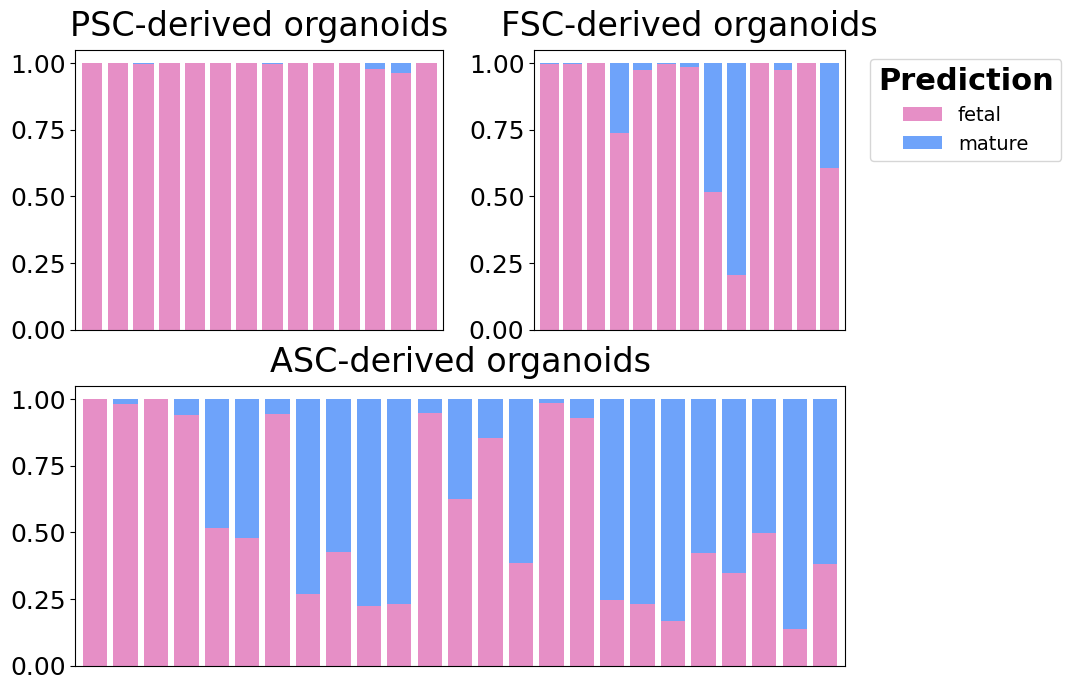

In [51]:
# Generate barplot
proportions_fsc = proportions[proportions['derive'] == 'FSC']
proportions_asc = proportions[proportions['derive'] == 'ASC']
proportions_psc = proportions[proportions['derive'] == 'PSC']


num_bars_fsc = len(proportions_fsc)
num_bars_asc = len(proportions_asc)
num_bars_psc = len(proportions_psc)
summed_width = num_bars_asc + num_bars_psc
total_width = 10

width_fsc = total_width
width_asc = (num_bars_asc / (summed_width)) * total_width
width_psc = (num_bars_psc / (summed_width)) * total_width

fig = plt.figure(figsize=(14, 8))

gs = fig.add_gridspec(2, max(num_bars_psc, num_bars_fsc + num_bars_asc))

ax1 = fig.add_subplot(gs[1, :num_bars_psc+num_bars_fsc])
ax2 = fig.add_subplot(gs[0, :num_bars_psc-1])
ax3 = fig.add_subplot(gs[0, (num_bars_psc+2):num_bars_psc+num_bars_fsc])

proportions_asc[['fetal', 'mature']].plot(kind='bar', width = 0.8, stacked=True, ax=ax1, color=[color_palette[p] for p in ['fetal', 'mature']])
proportions_psc[['fetal', 'mature']].plot(kind='bar', width = 0.8, stacked=True, ax=ax2, color=[color_palette[p] for p in ['fetal', 'mature']])
proportions_fsc[['fetal', 'mature']].plot(kind='bar', width = 0.8, stacked=True, ax=ax3, color=[color_palette[p] for p in ['fetal', 'mature']])
ax1.set_title('ASC-derived organoids', fontsize=24, pad = 10)
ax2.set_title('PSC-derived organoids', fontsize=24, pad = 10)
ax3.set_title('FSC-derived organoids', fontsize=24, pad = 10)

ax3.legend(title='Prediction', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, frameon=True)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

ax1.get_legend().remove()
ax2.get_legend().remove()

ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
ax3.tick_params(axis='y', labelsize=18)

# Make font size of legend title larger and bold
ax3.get_legend().get_title().set_fontsize(22)
ax3.get_legend().get_title().set_fontweight('bold')

plt.show()


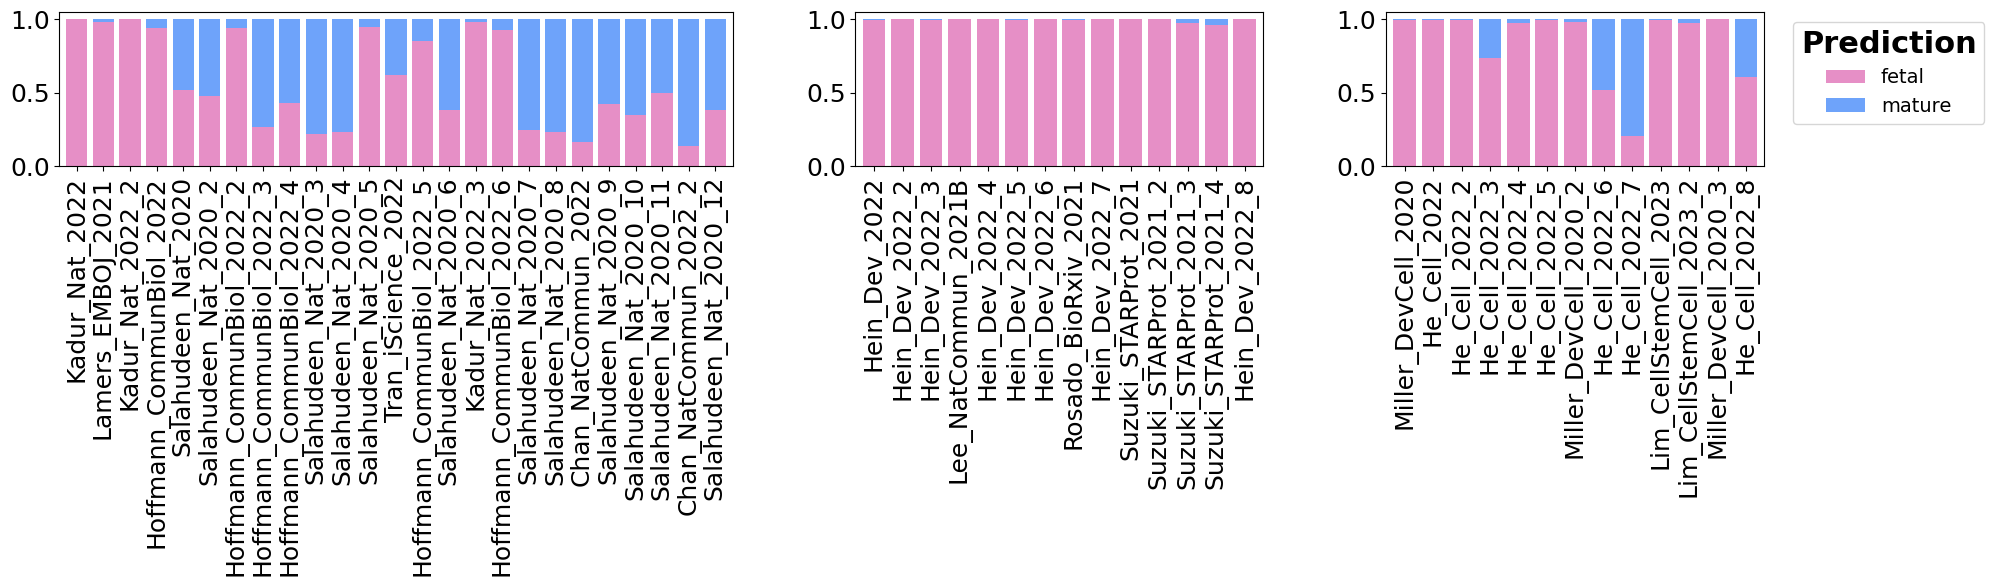

In [52]:
# Generate barplot reordered by other derivation order
proportions_fsc = proportions[proportions['derive'] == 'FSC']
proportions_asc = proportions[proportions['derive'] == 'ASC']
proportions_psc = proportions[proportions['derive'] == 'PSC']

num_bars_fsc = len(proportions_fsc)
num_bars_asc = len(proportions_asc)
num_bars_psc = len(proportions_psc)
summed_width = num_bars_asc + num_bars_psc + num_bars_fsc
total_width = 10

width_fsc = total_width
width_asc = (num_bars_asc / (summed_width)) * total_width
width_psc = (num_bars_psc / (summed_width)) * total_width

fig = plt.figure(figsize=(22, 2))

gs = fig.add_gridspec(1, summed_width+6)

ax1 = fig.add_subplot(gs[0, :num_bars_asc-2])
ax2 = fig.add_subplot(gs[0, num_bars_asc+2:num_bars_asc+num_bars_psc+2])
ax3 = fig.add_subplot(gs[0, num_bars_asc+num_bars_psc+6:num_bars_asc+num_bars_psc+num_bars_fsc+6])

proportions_asc[['fetal', 'mature']].plot(kind='bar', width = 0.8, stacked=True, ax=ax1, color=[color_palette[p] for p in ['fetal', 'mature']])
proportions_psc[['fetal', 'mature']].plot(kind='bar', width = 0.8, stacked=True, ax=ax2, color=[color_palette[p] for p in ['fetal', 'mature']])
proportions_fsc[['fetal', 'mature']].plot(kind='bar', width = 0.8, stacked=True, ax=ax3, color=[color_palette[p] for p in ['fetal', 'mature']])
ax1.set_title('', fontsize=22, pad = 10)
ax2.set_title('', fontsize=22, pad = 10)
ax3.set_title('', fontsize=22, pad = 10)

ax3.legend(title='Prediction', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, frameon=True)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

ax1.get_legend().remove()
ax2.get_legend().remove()

ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
ax3.tick_params(axis='y', labelsize=18)

ax1.tick_params(axis='x', labelsize=18)
ax2.tick_params(axis='x', labelsize=18)
ax3.tick_params(axis='x', labelsize=18)

ax3.get_legend().get_title().set_fontsize(22)
ax3.get_legend().get_title().set_fontweight('bold')

plt.show()

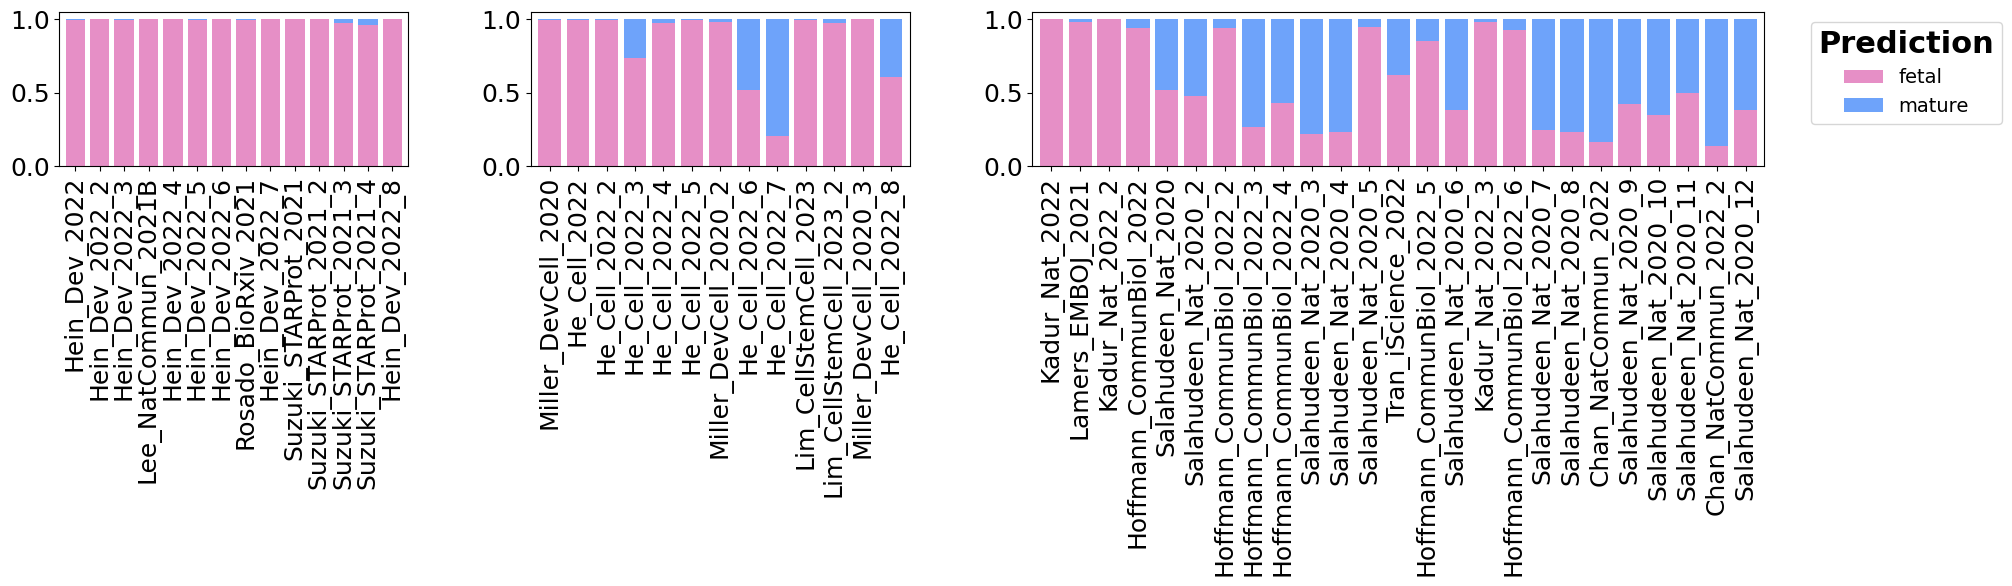

In [53]:
# Generate final barplot
proportions_fsc = proportions[proportions['derive'] == 'FSC']
proportions_asc = proportions[proportions['derive'] == 'ASC']
proportions_psc = proportions[proportions['derive'] == 'PSC']

num_bars_fsc = len(proportions_fsc)
num_bars_asc = len(proportions_asc)
num_bars_psc = len(proportions_psc)
summed_width = num_bars_asc + num_bars_psc + num_bars_fsc
total_width = 10

width_fsc = total_width
width_asc = (num_bars_asc / (summed_width)) * total_width
width_psc = (num_bars_psc / (summed_width)) * total_width

fig = plt.figure(figsize=(22, 2))

gs = fig.add_gridspec(1, summed_width+6)

ax1 = fig.add_subplot(gs[0, :num_bars_psc-2])
ax2 = fig.add_subplot(gs[0, num_bars_psc+2:num_bars_psc+num_bars_fsc+2])
ax3 = fig.add_subplot(gs[0, num_bars_psc+num_bars_fsc+6:num_bars_psc+num_bars_fsc+num_bars_asc+6])

proportions_psc[['fetal', 'mature']].plot(kind='bar', width = 0.8, stacked=True, ax=ax1, color=[color_palette[p] for p in ['fetal', 'mature']])
proportions_fsc[['fetal', 'mature']].plot(kind='bar', width = 0.8, stacked=True, ax=ax2, color=[color_palette[p] for p in ['fetal', 'mature']])
proportions_asc[['fetal', 'mature']].plot(kind='bar', width = 0.8, stacked=True, ax=ax3, color=[color_palette[p] for p in ['fetal', 'mature']])
ax1.set_title('', fontsize=22, pad = 10)
ax2.set_title('', fontsize=22, pad = 10)
ax3.set_title('', fontsize=22, pad = 10)

ax3.legend(title='Prediction', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, frameon=True)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

ax1.get_legend().remove()
ax2.get_legend().remove()

ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
ax3.tick_params(axis='y', labelsize=18)

ax1.tick_params(axis='x', labelsize=18)
ax2.tick_params(axis='x', labelsize=18)
ax3.tick_params(axis='x', labelsize=18)

ax3.get_legend().get_title().set_fontsize(22)
ax3.get_legend().get_title().set_fontweight('bold')

plt.show()

# Visualization of markers in reference UMAP

In [58]:
adata = sc.read('./datasets/heoca_lung_cellxgene.h5ad')

In [59]:
adata.obsm['X_scpoli'] = adata.obsm['X_umap']

In [60]:
embd_ref = sc.AnnData(adata.obsm['X_scpoli'])
embd_ref.obs_names = adata.obs_names
embd_ref.obs = adata.obs.copy()
embd_ref.obsm['X_umap'] = adata.obsm['X_umap']

In [65]:
markers = ['EPCAM', 'LGR5','OLFM4','ASCL2','TP63','KRT8','KRT14',
          'FOXJ1','MUC5AC', 'SCGB1A1','CC10','SFTPC','SFTPB',
          'PDPN','HOPX','CHGA','ASCL1','SCGB3A2']

markers_suppl = ['EPCAM', 'ASCL2','TP63','KRT8', 'CC10', 'PDPN']

markers = [x for x in markers if x in adata.var.index.tolist()]

markers_suppl = [x for x in markers_suppl if x in adata.var.index.tolist()]

In [66]:
adata_markers = adata[:, adata.var.index.isin(markers)].copy()
sc.pp.normalize_total(adata_markers, target_sum=1e6)
adata_markers = adata_markers.to_df()
embd_ref.obs = pd.concat((adata.obs, adata_markers), axis = 1)

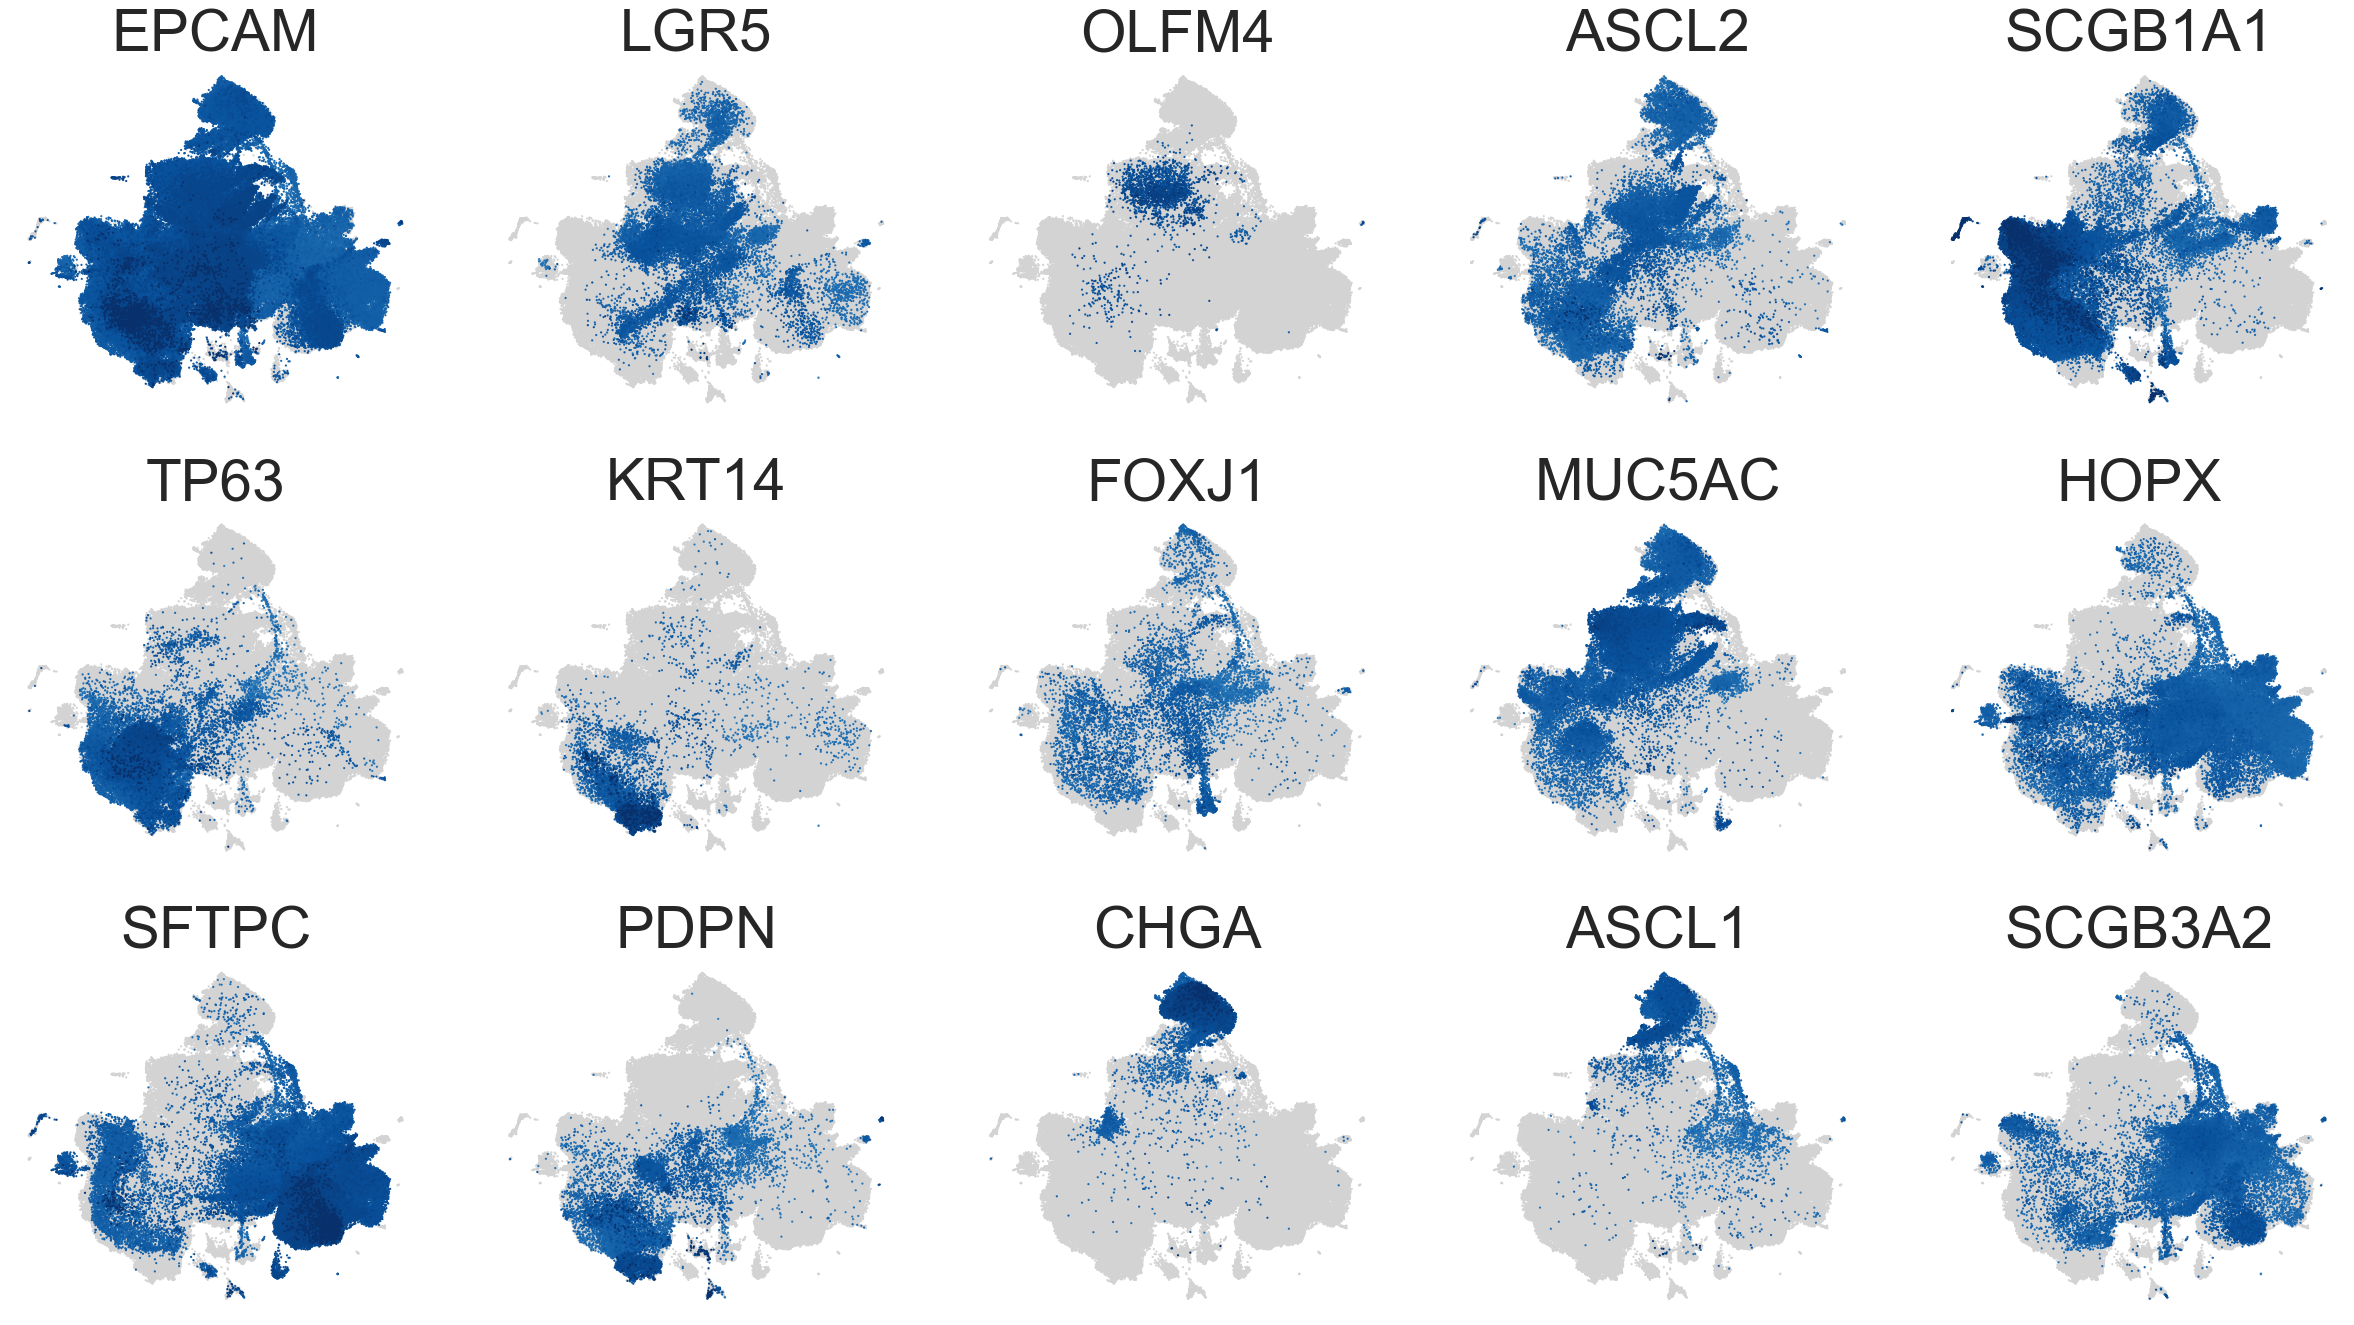

In [109]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["lightgray",'#7ec0e4','#2e79ba'])

sns.set(font_scale=3.5)

genes_sel = ['EPCAM',
            'LGR5','OLFM4','ASCL2', 'SCGB1A1', 'TP63', 'KRT14',
            'FOXJ1','MUC5AC', 'HOPX', 'SFTPC', 'PDPN', 'CHGA', 'ASCL1', 'SCGB3A2']

gns = mpl.cm.Blues
gns.set_bad('lightgray')
gns.set_under('lightgray')

adata_sort = adata[:, adata.var.index.isin(genes_sel)].copy()
adata_sort.var = adata_sort.var.reindex(genes_sel)

with mpl.rc_context({'figure.figsize': (5, 5)}):
        sc.pl.umap(embd_ref, color= adata_sort.var.index, size =10, colorbar_loc=None,
                color_map=gns, title= adata_sort.var.index,
                ncols=5, frameon=False, show=True, vmin = 5
                )